# Sparse Neural Networks are Slow (Sometimes)
> An example of how the sparsity level affects runtime of sparse matrix operations

- toc: false 
- badges: false
- comments: false
- categories: [jupyter, sparsity]
- image: images/thumb_sized/sparsemath.png
- author: Mathias Lechner

## Sprase neural networks

Pruning is a well-established technique for compressing neural networks before deployment in order to make them run faster.
The compression process removes connections from the network that are considered unimportant. The pruned connections have only a minor impact on the total accuracy of the network but potentially speedups the inference of the network as fewer connections need to be computed.

![](https://mlech26l.github.io/pages/images/wormnet/sparse/sparse.png)

On a more technical level, the connections inside a neural network layer are realized as a matrix multiplication:

$$ y = ReLU\Big(\ \begin{pmatrix} 0.05  & -1.2 & -0.12 \\2.7 & 0.09 & 0.73 \\ -0.62  & 0.3 & -0.04 \end{pmatrix}\ \cdot x\Big) $$

The pruning algorithm removes connections from the network by setting the corresponding entries in the weight matrix to zero, i.e., making the matrix sparse. The semantics after pruning of the layer may look something like

$$ y = ReLU\Big(\ \begin{pmatrix} 0  & -1.2 & 0 \\2.7 & 0 & 0.73 \\ -0.62  & 0.3 & 0 \end{pmatrix}\ \cdot x\Big) $$

Despite the pruned matrix looking much simpler than the densely populated one, turning this sparsity into an improvement in computational efficiency is not trivial.
This is because a dense matrix can be stored in an array, i.e., a consecutive block of memory where each item takes up the same number of bytes. In this array format, we don't worry about which matrix entry belongs to which array index, as they follow the relationship
$$ W_{i,j} = \text{array}[i \cdot \text{num_columns} + j] $$
where *num_columns* corresponds to the number of rows of the matrix.

For sparse matrices, however, using this array format would not provide any memory or computation benefits because there would be a large amount of redundant zero stored in the array.
The [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix) and other sparse formats avoid this problem by storing only the non-zero entries of the matrix. Contrary to the dense array format, the CSR scheme needs to store not only the values of the matrix but also the indices, i.e., to distinguish between zero and non-zero entries. For instance, a matrix in the CSR format is represented in the form of three arrays, i.e., the column indices, the row indices, and the values themselves.
Let's visualize this on a code example:

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import time

def create_sparse_mat(size, sparsity_level):
    rng = np.random.default_rng(int(size*100*sparsity_level))
    mask = rng.choice(2,size=(size,size),p=[sparsity_level,1.0-sparsity_level])
    mat = rng.normal(size=(size,size))
    mat = mat * mask
    sparse_mat = csr_matrix(mat)
    return mat,sparse_mat

A,A_sparse = create_sparse_mat(3,0.8)    
print("A=",A)
print("A_sparse=",A_sparse)

A= [[-0.          0.         -0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.24214645]]
A_sparse=   (2, 2)	0.24214644868677146


## Dense and Sparse matrix operations

Obviously, the algorithms for implementing matrix operations, e.g., matrix-vector or matrix-matrix products, look quite different for densely and sparsely represented matrices. Without going into too much detail, on the one hand, the dense matrix-vector algorithm needs to iterate over a single block of memory, i.e., the array storing the matrix. On the other hand, a sparse matrix-vector algorithm also needs to traverse over three arrays, i.e., the columns, the rows, and the values, tripling the amount of memory that needs to be accessed [^1].
In a nutshell, a sparse representation adds some overhead to matrix operations compared to densely stored matrices.

The question that we now have is, at what sparsity level do the sparse matrix operations become more efficient than their dense counterparts?
We can make a first rough estimation from the memory requirement of the CSR format. As the amount of memory is at least double the number of non-zero entries, we can expect sparse operations to be slower if the sparsity level is below 50%.
We try to answer this question empirically to get a more accurate picture. In particular, we look at the runtime of matrix-vector products and vary the number of matrix entries that are zeros:

[^1]: The CSR format compresses the space required to store the row indices. Thus, the required memory is less than triple the amount for a dense matrix, but nonetheless, more than double.

In [2]:
def measure_dot_time(mat,x,n=20):
    start_time = time.perf_counter()
    for i in range(n):
        x = mat.dot(x)
    return 1000.0*(time.perf_counter()-start_time ) # in milliseconds

SIZE = 8192
sparsity_levels = [0,0.3,0.5,0.8,0.85,0.9,0.95,0.97,0.99]
dense_times, sparse_times = [],[]
[np.eye(SIZE).dot(np.ones(SIZE)) for i in range(10)] # Warump CPU
for sp in sparsity_levels:
    A, A_sparse = create_sparse_mat(SIZE,sp)
    x = np.random.default_rng(123).normal(size=SIZE)
    dense_times.append(measure_dot_time(A,x))
    sparse_times.append(measure_dot_time(A_sparse,x))
    
df = pd.DataFrame.from_dict({"Sparsity":sparsity_levels, "Dense times": dense_times, "Sparse times": sparse_times })
df

,Sparsity,Dense times,Sparse times
0,0.00,277.155751,1198.099483
1,0.30,198.768542,828.013037
2,0.50,181.478204,598.241222
3,0.80,223.341304,253.423730
4,0.85,295.475303,193.573917
5,0.90,278.725468,136.714651
6,0.95,220.195333,78.846820
7,0.97,320.193510,52.913228
8,0.99,178.455228,18.715560


In the two extreme cases, i.e., 0% and 99%, we can see a significant difference in terms of performance. For a fully populated matrix, the matrix-vector product is three times slower than the operation carried out in a sparse storage format. Conversely, if the matrix consists of 99% zero entries, the sparse representation is approximately 20 times faster.
  
Let's plot our results to get a nice visual presentation.

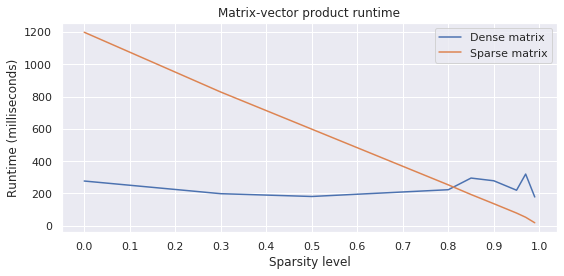

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(df["Sparsity"],df["Dense times"])
ax.plot(df["Sparsity"],df["Sparse times"])
ax.set_xlabel("Sparsity level")
ax.set_ylabel("Runtime (milliseconds)")
ax.legend(["Dense matrix","Sparse matrix"],loc="upper right")
ax.set_xticks(np.linspace(0,1,11))
ax.set_title("Matrix-vector product runtime")
fig.tight_layout()

We observe that below 80% sparsity, the dense matrix operations clearly outperforms the CSR matrix-vector product.
It takes a sparsity level of around 80% for the operation to catch up and perform on par with the dense format. 
A meaningful speedup is measured starting from a 90% sparsity level. 


## Conclusion

We have seen that a sparse neural network is not necessarily more efficient than a fully-connected model. 
Our experiments have shown a sparsity level of above 90% is necessary to see any advantage when running our networks on the CPU.
Note that we might need a much higher sparsity level on highly parallel GPU devices before seeing any performance improvement compared to dense matrix operations.